In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 

%matplotlib inline

import random
random.seed(123)

## Data Preparation

In [2]:
meta_df_1000 = pd.read_parquet('meta_df_1000_cleaned.parquet')
reviews_df = pd.read_parquet('reviews_df_clean.parquet')

In [3]:
merged_df = pd.merge(meta_df_1000, reviews_df, on='asin', how='inner')
merged_df['category_1'] = merged_df.category.apply(lambda x: x[1])
merged_df['rating'] = merged_df['rating'].astype(float)
merged_df.head()

,category,description,title_x,also_buy,brand,feature,rank,also_view,main_cat,date_x,...,title_y,content,date_y,author,rating,found_helpful,variant,verified_purchase,product,category_1
0,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,One Star,didn't work... If I could've given it zero sta...,2018-06-28,Margie,1.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
1,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Bible book light,Gave as a gift to my brother who teaches Sunda...,2017-03-07,Dolphin6411,5.0,0,None,True,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
2,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,I also love this reading light,I also love this reading light. I've had mine...,2014-08-08,Nancy,5.0,1,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
3,"[Electronics, eBook Readers & Accessories, Rea...",\n,"Thinking Gifts Folding Booklight, Blue, 1 unit...",[],,,"[[Books , 3,563,332]]",[],Books,,...,Great Reading Light,I am buying the second one of these. I used th...,2011-10-24,James G.,5.0,7,None,False,"Thinking Gifts Folding Booklight, Blue, 1 unit...",eBook Readers & Accessories
4,"[Electronics, Accessories & Supplies, Audio & ...",Slim Port Adapter for LG G3 Smartphone! MyDP /...,SlimPort sli44532 Adapter for LG G3 Smartphone...,[],SlimPort,This SlimPort/MyDp adapter is specifically des...,[[Electronics > Accessories & Supplies > Audio...,"[B00HFYLR4M, B015DJ4QYI, 9791688974, B00B2HORK...",Computers,,...,Ease of use,Worked well,2022-10-22,Malcolm W. Collins,4.0,0,Color: Black,True,SlimPort sli44532 Adapter for LG G3 Smartphone...,Accessories & Supplies


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5921 entries, 0 to 5920
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           5921 non-null   object        
 1   description        5921 non-null   object        
 2   title_x            5921 non-null   object        
 3   also_buy           5921 non-null   object        
 4   brand              5921 non-null   object        
 5   feature            5921 non-null   object        
 6   rank               5921 non-null   object        
 7   also_view          5921 non-null   object        
 8   main_cat           5921 non-null   object        
 9   date_x             5921 non-null   object        
 10  price              3066 non-null   float64       
 11  asin               5921 non-null   object        
 12  title_y            5921 non-null   object        
 13  content            5921 non-null   object        
 14  date_y  

In [5]:
merged_df['content'].head(10)

0    didn't work... If I could've given it zero sta...
1    Gave as a gift to my brother who teaches Sunda...
2    I also love this reading light.  I've had mine...
3    I am buying the second one of these. I used th...
4                                          Worked well
5    I had given this item a 1 star and bad review ...
6    I have an LG G3 and love the quality of watchi...
7    Worked perfectly. One side goes into the LG G3...
8    not sure if this adapter is slowing down my ch...
9    The item is a great idea.  I had the same expe...
Name: content, dtype: object

In [6]:
# sampling dataframe to simplify data
# merged_df = merged_df[merged_df['category_1'].isin(list(merged_df['category_1'].value_counts()[:4].index))].groupby('category_1').sample(50)
merged_df = merged_df[merged_df['category_1']\
                    .isin(['Computers & Accessories', 'Camera & Photo', 
                           'Accessories & Supplies', 'Headphones', 'Car & Vehicle Electronics'])]

In [7]:
merged_df['category_1'].value_counts()

Computers & Accessories      2097
Camera & Photo               1413
Accessories & Supplies        901
Headphones                    345
Car & Vehicle Electronics     259
Name: category_1, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm')
merged_df['tokens'] = merged_df['content'].apply(lambda x: nlp(x.lower())) 
merged_df.tokens

4                                          (worked, well)
5       (i, had, given, this, item, a, 1, star, and, b...
6       (i, have, an, lg, g3, and, love, the, quality,...
7       (worked, perfectly, ., one, side, goes, into, ...
8       (not, sure, if, this, adapter, is, slowing, do...
                              ...                        
5916    (i, love, this, monitor, !, i, went, through, ...
5917    (i, bought, this, turd, for, my, 2016, macbook...
5918    (i, installed, these, in, my, jeep, ., super, ...
5919    (great, sound, ., my, son, had, them, installe...
5920       (came, as, described, .,  , no, complaints, .)
Name: tokens, Length: 5015, dtype: object

In [9]:
merged_df['tokens'] = merged_df.tokens.apply(lambda x: [w.lemma_ for w in x if not w.is_stop and not w.is_punct and w.lemma_!=' '])

In [10]:
merged_df['tokens'] = merged_df['tokens'].apply(lambda x: ' '.join(x))
merged_df['tokens'].head(10)

4                                                  work
5     give item 1 star bad review not give instructi...
6     lg g3 love quality watch video love transfer l...
7     work perfectly go lg g3 t mobile connect hdmi ...
8     sure adapter slow charger tablet battery drain...
9     item great idea experience device flash work w...
10    work great play movie phone travel sturdy micr...
11    work careful insert completely phone take bit ...
12    packaging description external construction un...
13    say amazon work lg 3smartphone box ship plainl...
Name: tokens, dtype: object

In [11]:
vectorizer = TfidfVectorizer(max_df=0.7)
tokens_vectorized = vectorizer.fit_transform(merged_df['tokens'])
tokens_vectorized

<5015x12814 sparse matrix of type '<class 'numpy.float64'>'
	with 155047 stored elements in Compressed Sparse Row format>

In [12]:
tokens_vectorized.shape

(5015, 12814)

In [72]:
from sklearn.preprocessing import StandardScaler, normalize, scale
# sc = StandardScaler(with_mean=False)
# norm_tokens = sc.fit_transform(tokens_vectorized.toarray())
norm_tokens = scale(tokens_vectorized, with_mean=False, axis=0)
# norm_tokens = normalize(tokens_vectorized, axis=0)

In [73]:
np.mean(norm_tokens.toarray(), axis = 0), np.std(norm_tokens.toarray(), axis = 0)

(array([0.06991235, 0.04788266, 0.01412238, ..., 0.01412238, 0.01412238,
        0.01412238]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [110]:
pd.DataFrame(norm_tokens.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(norm_tokens.shape[0]), 20), random.sample(range(norm_tokens.shape[1]), 15)]

,dosnet,curious,gee,enabling,jostle,5820k,overnight,allergic,crease,palm,crop,week,20,cover,environment
3514,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
231,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1299,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4272,0.0,0.0,0.0,70.823726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.824141,0.0,0.0,0.0
2661,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4233,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4216,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4559,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1125,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2814,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [17]:
pd.DataFrame(norm_tokens.toarray(), columns=vectorizer.get_feature_names_out()).sample(500).to_csv('tokens_tfidf_vectorized_norm_sample.csv')


In [112]:
X_train, X_test, y_train, y_test = train_test_split(norm_tokens, merged_df['category_1'], test_size=0.2)

In [113]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4012, 12814), (1003, 12814), (4012,), (1003,))

In [119]:
pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(X_train.shape[0]), 20), random.sample(range(X_train.shape[1]), 15)]
# y_test.sample(10)

,285hvs,14t,lazy,stadium,gear,prosafe,32,551000000,dress,untie,managing,tipped,fearful,content,fly
2679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.57796,0.0,0.0,0.0
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [121]:
pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out()).iloc[random.sample(range(X_test.shape[0]), 20), random.sample(range(X_test.shape[1]), 15)]


,war,art,room,stretchy,gh,usv,amazement,zip,subsequent,cybershot,interchange,concert,light,bloated,nice
124,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.359973
471,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
948,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
882,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
361,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
565,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
629,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
17,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
455,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,4.131064,0.0,1.204455
533,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [76]:
# vectorizer.vocabulary_['ear']
# X_train.shape
# X_train = X_train[:, [i for i in range(X_train.shape[1]) if i != 650]]
feat_names = list(vectorizer.get_feature_names_out())
# feat_names.pop(650)
# feat_names[650]

In [77]:
clf_svm1 = SVC(C=1.0, kernel='linear', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm1.fit(X_train, y_train)

SVC(kernel='linear')

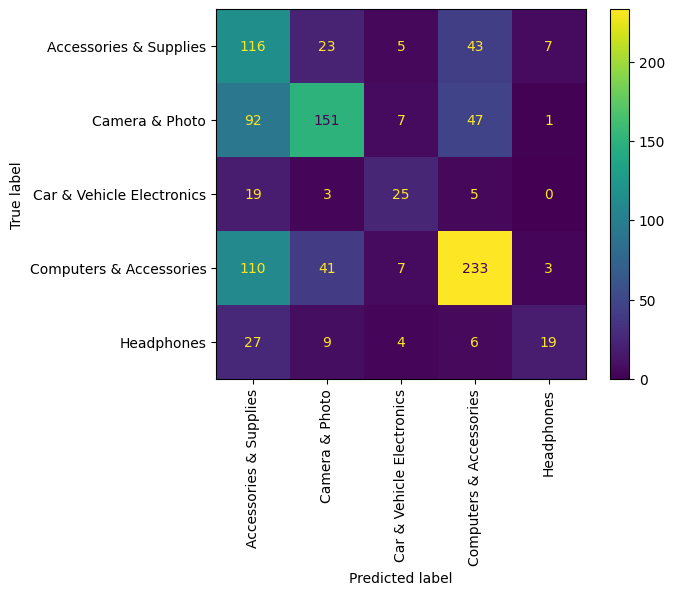

acc 0.5423728813559322
                           precision    recall  f1-score   support

   Accessories & Supplies       0.32      0.60      0.42       194
           Camera & Photo       0.67      0.51      0.58       298
Car & Vehicle Electronics       0.52      0.48      0.50        52
  Computers & Accessories       0.70      0.59      0.64       394
               Headphones       0.63      0.29      0.40        65

                 accuracy                           0.54      1003
                macro avg       0.57      0.49      0.51      1003
             weighted avg       0.60      0.54      0.55      1003



In [78]:
y_pred = clf_svm1.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm1.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [79]:
clf_svm2 = SVC(C=1.4, kernel='linear', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm2.fit(X_train, y_train)

SVC(C=1.4, kernel='linear')

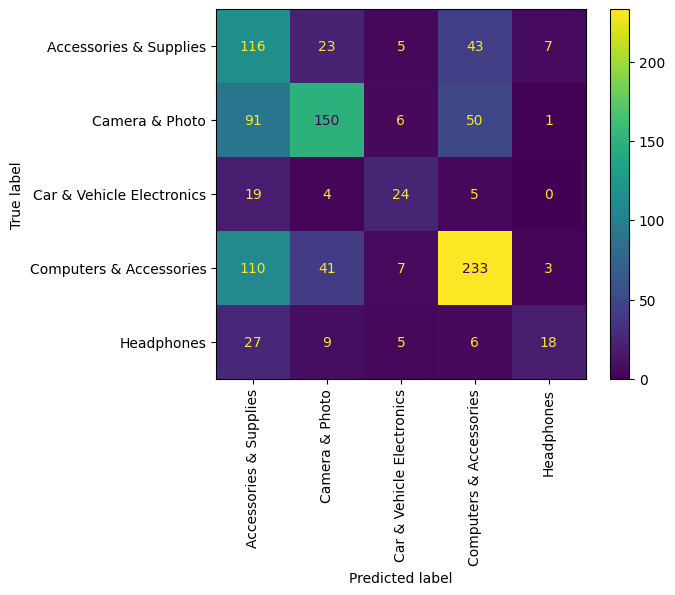

acc 0.53938185443669
                           precision    recall  f1-score   support

   Accessories & Supplies       0.32      0.60      0.42       194
           Camera & Photo       0.66      0.50      0.57       298
Car & Vehicle Electronics       0.51      0.46      0.48        52
  Computers & Accessories       0.69      0.59      0.64       394
               Headphones       0.62      0.28      0.38        65

                 accuracy                           0.54      1003
                macro avg       0.56      0.49      0.50      1003
             weighted avg       0.60      0.54      0.55      1003



In [80]:
y_pred = clf_svm2.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm2.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [81]:
clf_svm2 = SVC(C=1.6, kernel='linear', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm2.fit(X_train, y_train)

SVC(C=1.6, kernel='linear')

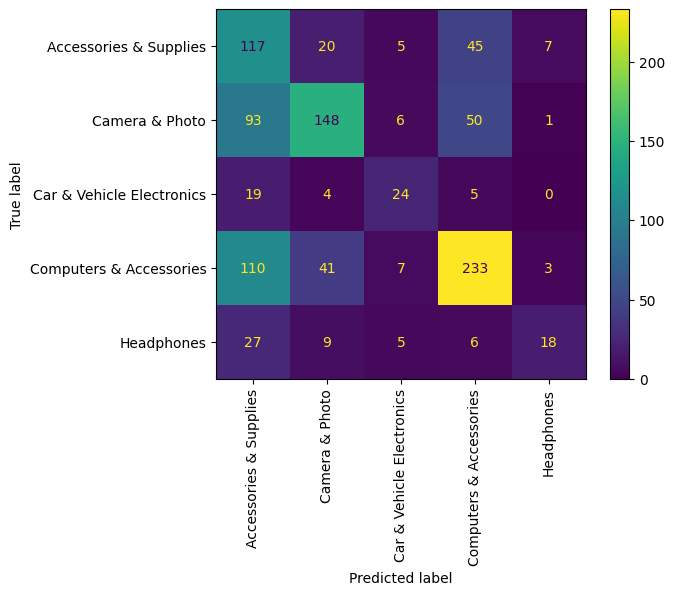

acc 0.5383848454636092
                           precision    recall  f1-score   support

   Accessories & Supplies       0.32      0.60      0.42       194
           Camera & Photo       0.67      0.50      0.57       298
Car & Vehicle Electronics       0.51      0.46      0.48        52
  Computers & Accessories       0.69      0.59      0.64       394
               Headphones       0.62      0.28      0.38        65

                 accuracy                           0.54      1003
                macro avg       0.56      0.49      0.50      1003
             weighted avg       0.60      0.54      0.55      1003



In [82]:
y_pred = clf_svm2.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm2.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [83]:
clf_svm2 = SVC(C=0.8, kernel='linear', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm2.fit(X_train, y_train)

SVC(C=0.8, kernel='linear')

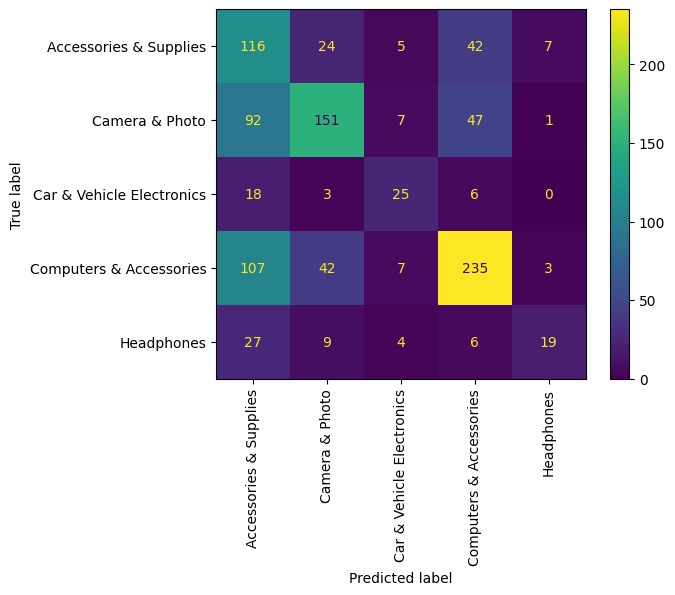

acc 0.5443668993020937
                           precision    recall  f1-score   support

   Accessories & Supplies       0.32      0.60      0.42       194
           Camera & Photo       0.66      0.51      0.57       298
Car & Vehicle Electronics       0.52      0.48      0.50        52
  Computers & Accessories       0.70      0.60      0.64       394
               Headphones       0.63      0.29      0.40        65

                 accuracy                           0.54      1003
                macro avg       0.57      0.49      0.51      1003
             weighted avg       0.60      0.54      0.56      1003



In [84]:
y_pred = clf_svm2.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm2.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [85]:
clf_svm3 = SVC(C=1, kernel='poly', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm3.fit(X_train, y_train)

SVC(C=1, kernel='poly')

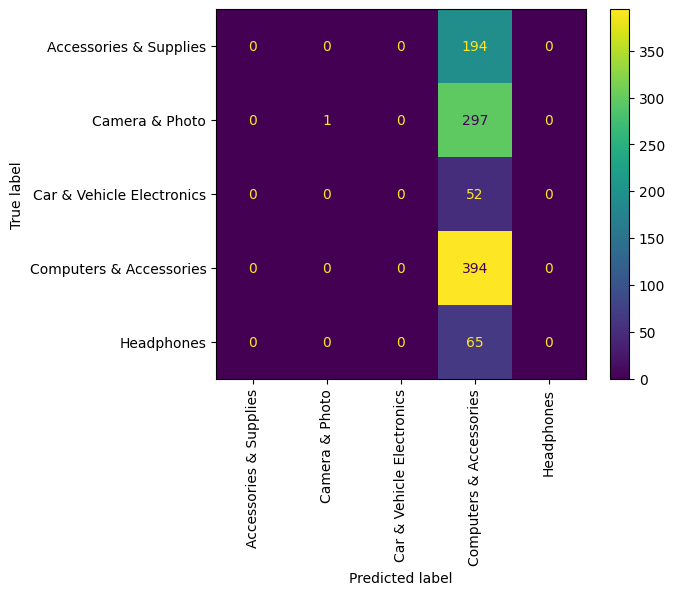

acc 0.3938185443668993
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.00      0.01       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.39      1.00      0.56       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.39      1003
                macro avg       0.28      0.20      0.11      1003
             weighted avg       0.45      0.39      0.22      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
y_pred = clf_svm3.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm3.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [87]:
clf_svm3 = SVC(C=1.2, kernel='poly', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm3.fit(X_train, y_train)

SVC(C=1.2, kernel='poly')

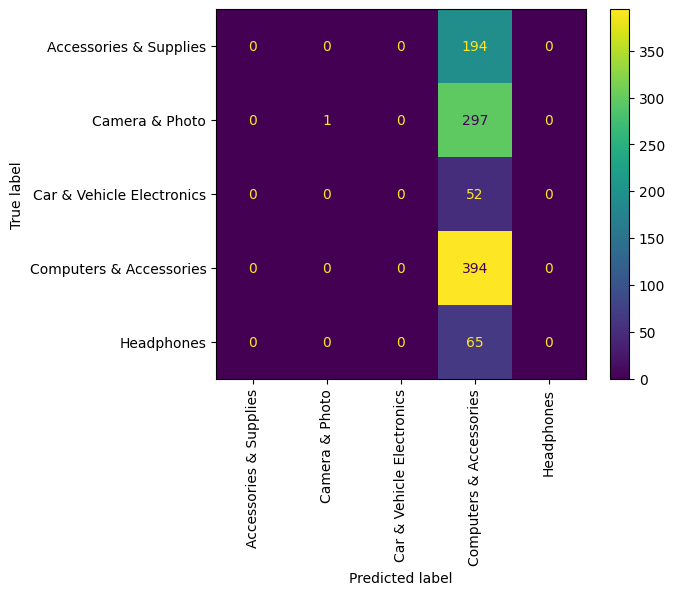

acc 0.3938185443668993
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.00      0.01       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.39      1.00      0.56       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.39      1003
                macro avg       0.28      0.20      0.11      1003
             weighted avg       0.45      0.39      0.22      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
y_pred = clf_svm3.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm3.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [89]:
clf_svm3 = SVC(C=1.4, kernel='poly', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm3.fit(X_train, y_train)

SVC(C=1.4, kernel='poly')

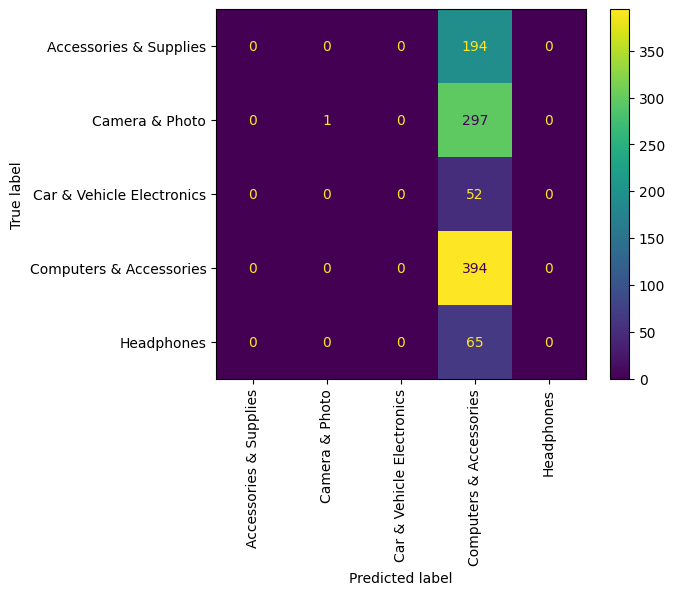

acc 0.3938185443668993
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.00      0.01       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.39      1.00      0.56       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.39      1003
                macro avg       0.28      0.20      0.11      1003
             weighted avg       0.45      0.39      0.22      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
y_pred = clf_svm3.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm3.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [39]:
clf_svm3 = SVC(C=0.8, kernel='poly', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm3.fit(X_train, y_train)

SVC(C=0.8, kernel='poly')

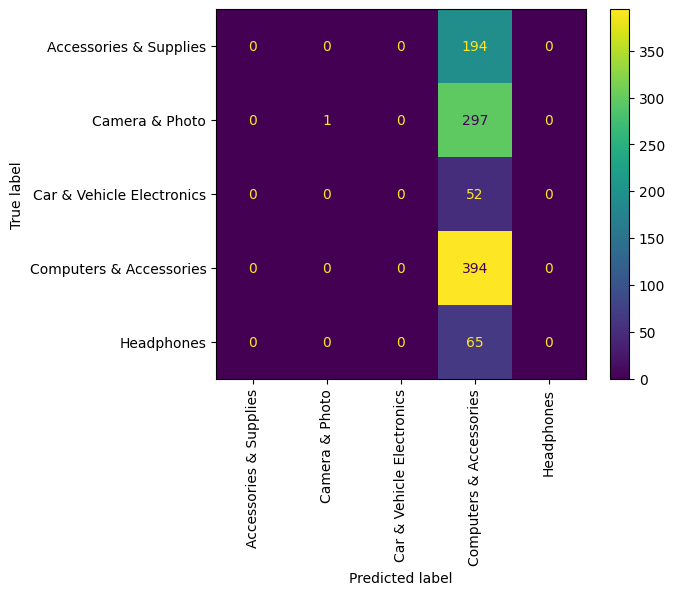

acc 0.3938185443668993
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.00      0.01       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.39      1.00      0.56       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.39      1003
                macro avg       0.28      0.20      0.11      1003
             weighted avg       0.45      0.39      0.22      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
y_pred = clf_svm3.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm3.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [92]:
clf_svm4 = SVC(C=1, kernel='rbf', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm4.fit(X_train, y_train)

SVC(C=1)

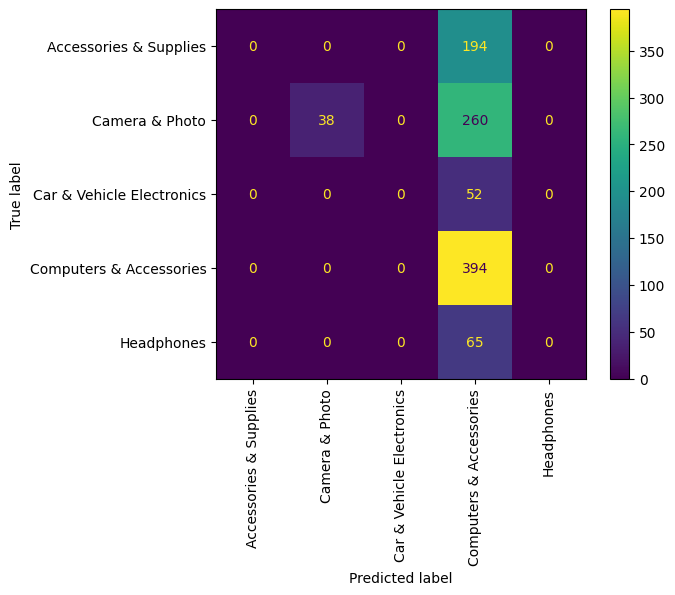

acc 0.4307078763708873
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.13      0.23       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.41      1.00      0.58       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.43      1003
                macro avg       0.28      0.23      0.16      1003
             weighted avg       0.46      0.43      0.29      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
y_pred = clf_svm4.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm4.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [94]:
clf_svm4 = SVC(C=1.2, kernel='rbf', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm4.fit(X_train, y_train)

SVC(C=1.2)

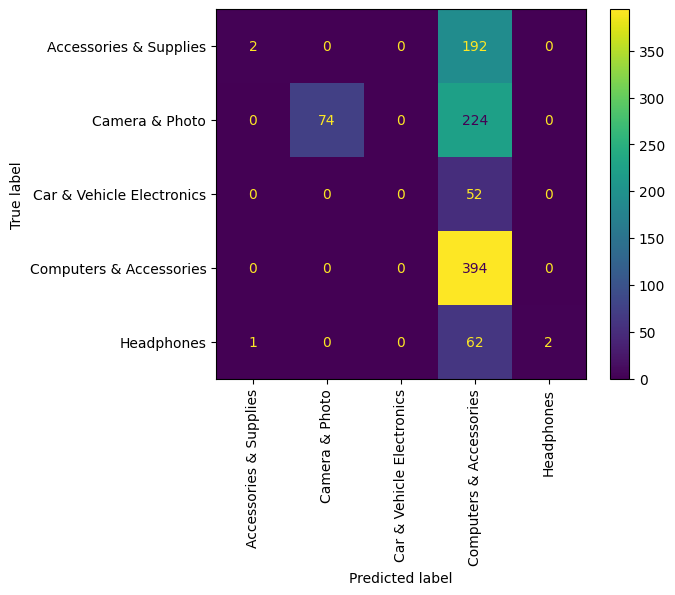

acc 0.47058823529411764
                           precision    recall  f1-score   support

   Accessories & Supplies       0.67      0.01      0.02       194
           Camera & Photo       1.00      0.25      0.40       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.43      1.00      0.60       394
               Headphones       1.00      0.03      0.06        65

                 accuracy                           0.47      1003
                macro avg       0.62      0.26      0.22      1003
             weighted avg       0.66      0.47      0.36      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
y_pred = clf_svm4.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm4.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [96]:
clf_svm4 = SVC(C=1.5, kernel='rbf', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm4.fit(X_train, y_train)

SVC(C=1.5)

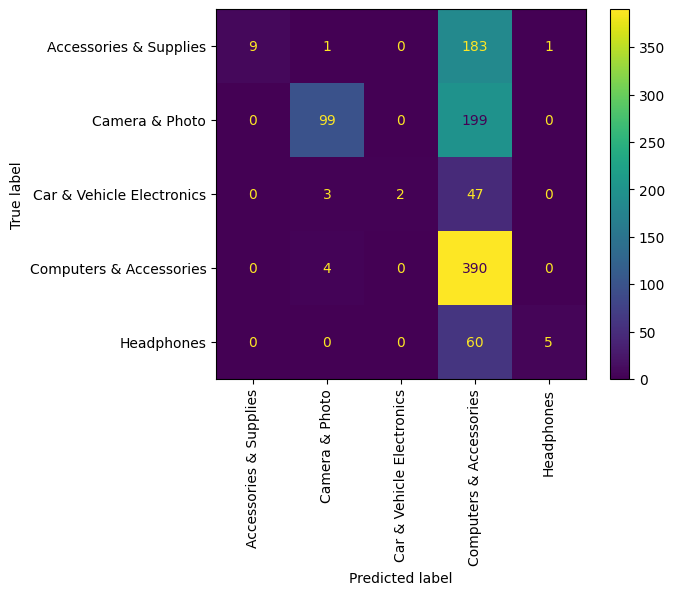

acc 0.5034895314057827
                           precision    recall  f1-score   support

   Accessories & Supplies       1.00      0.05      0.09       194
           Camera & Photo       0.93      0.33      0.49       298
Car & Vehicle Electronics       1.00      0.04      0.07        52
  Computers & Accessories       0.44      0.99      0.61       394
               Headphones       0.83      0.08      0.14        65

                 accuracy                           0.50      1003
                macro avg       0.84      0.30      0.28      1003
             weighted avg       0.75      0.50      0.42      1003



In [97]:
y_pred = clf_svm4.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm4.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [98]:
clf_svm5 = SVC(C=0.8, kernel='rbf', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm5.fit(X_train, y_train)

SVC(C=0.8)

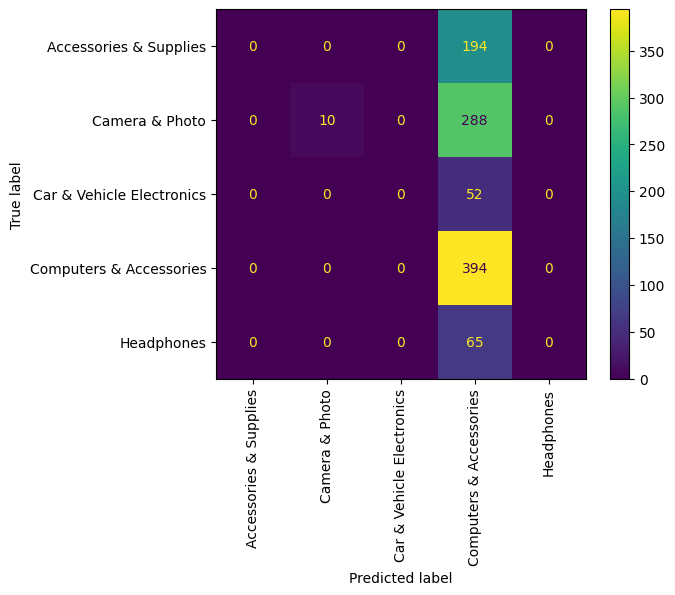

acc 0.40279162512462613
                           precision    recall  f1-score   support

   Accessories & Supplies       0.00      0.00      0.00       194
           Camera & Photo       1.00      0.03      0.06       298
Car & Vehicle Electronics       0.00      0.00      0.00        52
  Computers & Accessories       0.40      1.00      0.57       394
               Headphones       0.00      0.00      0.00        65

                 accuracy                           0.40      1003
                macro avg       0.28      0.21      0.13      1003
             weighted avg       0.45      0.40      0.24      1003



/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anupbhutada/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
y_pred = clf_svm5.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm5.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [100]:
X_train, X_test, y_train, y_test = train_test_split(tokens_vectorized, merged_df['category_1'], test_size=0.2)

In [101]:
clf_svm6 = SVC(C=1.2, kernel='linear', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm6.fit(X_train, y_train)

SVC(C=1.2, kernel='linear')

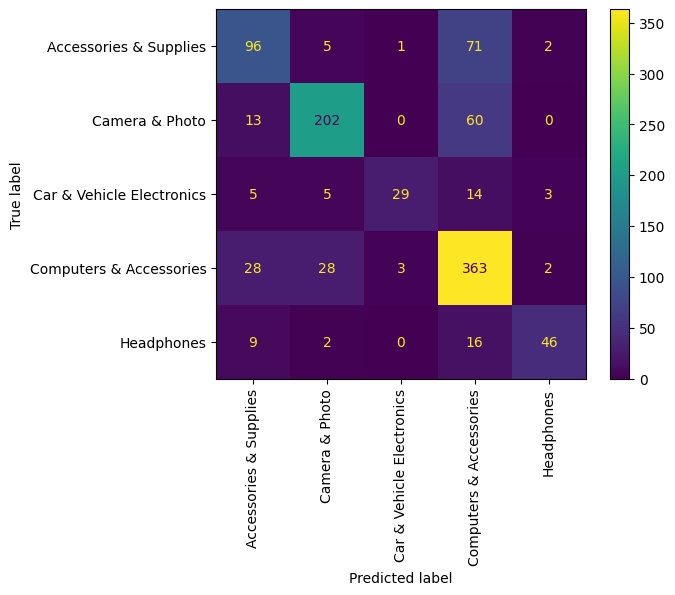

acc 0.7337986041874377
                           precision    recall  f1-score   support

   Accessories & Supplies       0.64      0.55      0.59       175
           Camera & Photo       0.83      0.73      0.78       275
Car & Vehicle Electronics       0.88      0.52      0.65        56
  Computers & Accessories       0.69      0.86      0.77       424
               Headphones       0.87      0.63      0.73        73

                 accuracy                           0.73      1003
                macro avg       0.78      0.66      0.70      1003
             weighted avg       0.74      0.73      0.73      1003



In [102]:
y_pred = clf_svm6.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm6.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [103]:
clf_svm7 = SVC(C=1.2, kernel='rbf', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm7.fit(X_train, y_train)

SVC(C=1.2)

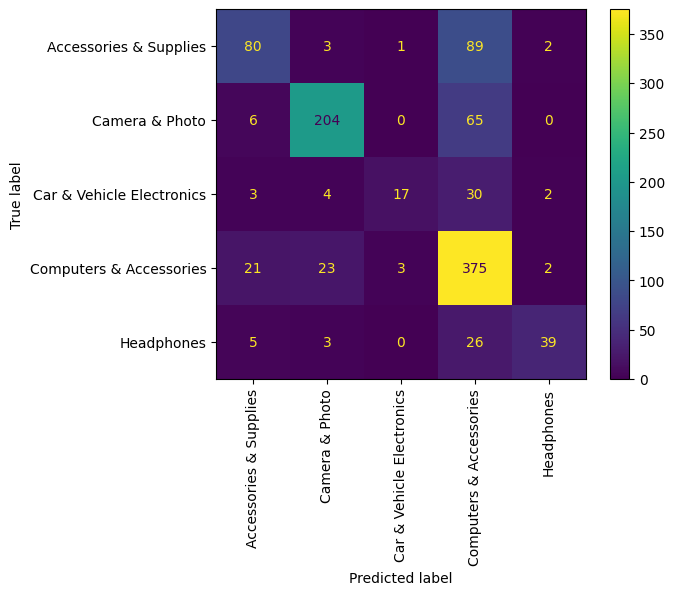

acc 0.7128614157527418
                           precision    recall  f1-score   support

   Accessories & Supplies       0.70      0.46      0.55       175
           Camera & Photo       0.86      0.74      0.80       275
Car & Vehicle Electronics       0.81      0.30      0.44        56
  Computers & Accessories       0.64      0.88      0.74       424
               Headphones       0.87      0.53      0.66        73

                 accuracy                           0.71      1003
                macro avg       0.77      0.58      0.64      1003
             weighted avg       0.74      0.71      0.70      1003



In [104]:
y_pred = clf_svm7.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm7.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [105]:
clf_svm8 = SVC(C=1.2, kernel='poly', degree=3, 
              gamma='scale', coef0=0.0, 
              shrinking=True, probability=False, 
              tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, 
              max_iter=-1, decision_function_shape='ovr', 
              break_ties=False, random_state=None)

clf_svm8.fit(X_train, y_train)

SVC(C=1.2, kernel='poly')

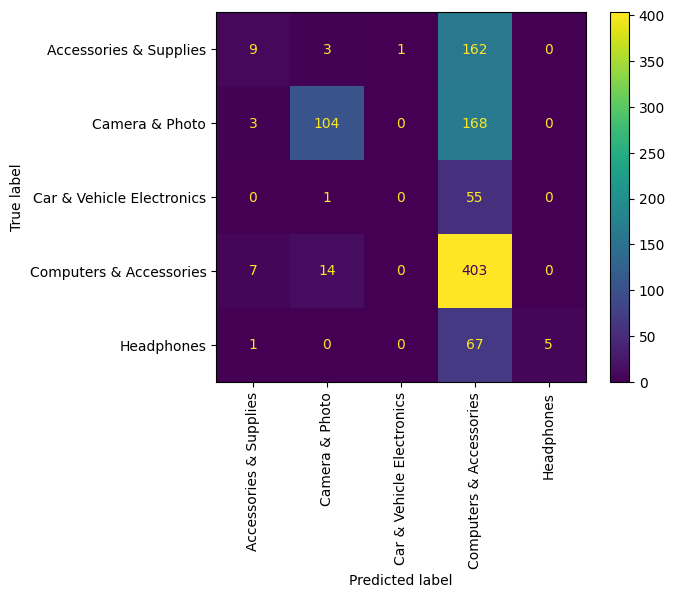

acc 0.5194416749750748
                           precision    recall  f1-score   support

   Accessories & Supplies       0.45      0.05      0.09       175
           Camera & Photo       0.85      0.38      0.52       275
Car & Vehicle Electronics       0.00      0.00      0.00        56
  Computers & Accessories       0.47      0.95      0.63       424
               Headphones       1.00      0.07      0.13        73

                 accuracy                           0.52      1003
                macro avg       0.55      0.29      0.27      1003
             weighted avg       0.58      0.52      0.44      1003



In [106]:
y_pred = clf_svm8.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=clf_svm8.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [ ]:
accuracy_list = [0.5423728813559322, 0.53938185443669, 0.5383848454636092, 0.5443668993020937, 0.3938185443668993, 
                 0.3938185443668993, 0.3938185443668993, 0.3938185443668993, 0.4307078763708873, 0.47058823529411764, 
                 0.5034895314057827, 0.40279162512462613, 0.7337986041874377, 0.7128614157527418, 0.5194416749750748]

modelname_list = ['SVM(C=1.0, kernel="linear")', 'SVM(C=1.4, kernel="linear")', 'SVM(C=1.6, kernel="linear")', 'SVM(C=0.8, kernel="linear")', 'SVM(C=1.0, kernel="poly")',
                  'SVM(C=1.2, kernel="poly")', 'SVM(C=1.4, kernel="poly")', 'SVM(C=0.8, kernel="poly")', 'SVM(C=1.0, kernel="rbf")', 'SVM(C=1.2, kernel="rbf")',
                  'SVM(C=1.5, kernel="rbf")', 'SVM(C=0.8, kernel="rbf")', 'SVM(C=1.2, kernel="linear") (unscaled)', 'SVM(C=1.2, kernel="rbf") (unscaled)', 'SVM(C=1.2, kernel="poly") (unscaled)']

In [60]:
np.sum(tokens_vectorized.toarray()*tokens_vectorized.toarray(), axis=0)

array([0.73022941, 0.31456366, 0.00183825, ..., 0.00631691, 0.00464879,
       0.00620389])

In [61]:
np.std(tokens_vectorized.toarray(), axis=0)

(12814,)

In [69]:
np.std(tokens_vectorized.toarray(), axis=0)/np.sum(tokens_vectorized.toarray()*tokens_vectorized.toarray(), axis=0)

array([0.01648451, 0.02514855, 0.32932107, ..., 0.1776515 , 0.20708636,
       0.17926238])

In [97]:
np.std(norm_tokens.toarray(), axis=0)

array([0.01408659, 0.01410481, 0.01411956, ..., 0.01411956, 0.01411956,
       0.01411956])

In [101]:
normalize(tokens_vectorized.toarray()).shape

(5015, 12814)

In [102]:
np.sqrt((1 - np.mean(tokens_vectorized.toarray(), axis=0)**2/np.sum(tokens_vectorized.toarray()**2, axis=0))/5015)

array([0.01412096, 0.01412097, 0.01412097, ..., 0.01412097, 0.01412097,
       0.01412097])

In [18]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=4, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.01)

In [19]:
dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
label_names

['Accessories and Supplies',
 'Camera and Photo',
 'Car and Vehicle Electronics',
 'Computers and Accessories',
 'Headphones']

'dt_text_cat_classification1.pdf'

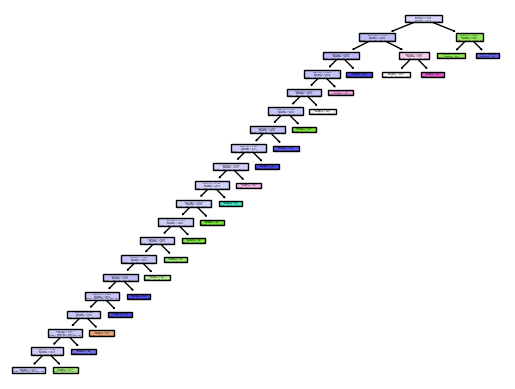

In [20]:

tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification1') 


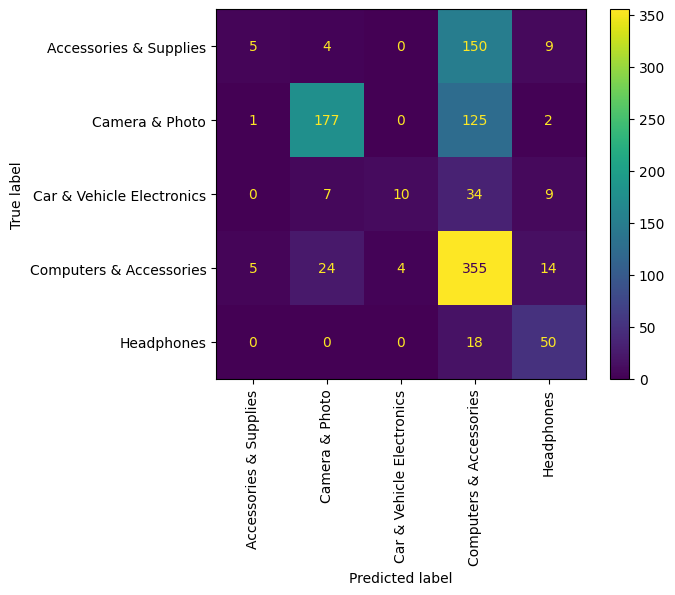

acc 0.5952143569292123
                           precision    recall  f1-score   support

   Accessories & Supplies       0.45      0.03      0.06       168
           Camera & Photo       0.83      0.58      0.68       305
Car & Vehicle Electronics       0.71      0.17      0.27        60
  Computers & Accessories       0.52      0.88      0.65       402
               Headphones       0.60      0.74      0.66        68

                 accuracy                           0.60      1003
                macro avg       0.62      0.48      0.46      1003
             weighted avg       0.62      0.60      0.54      1003



In [69]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification2.pdf'

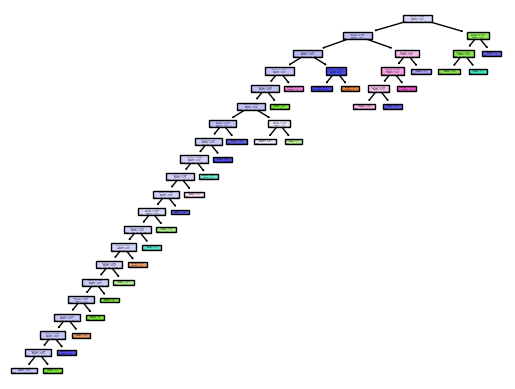

In [71]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',  
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.005)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification2') 


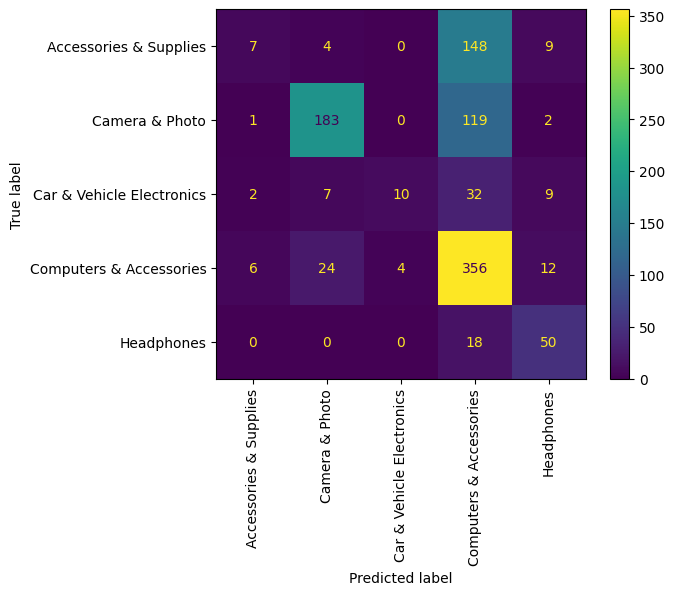

acc 0.6041874376869392
                           precision    recall  f1-score   support

   Accessories & Supplies       0.44      0.04      0.08       168
           Camera & Photo       0.84      0.60      0.70       305
Car & Vehicle Electronics       0.71      0.17      0.27        60
  Computers & Accessories       0.53      0.89      0.66       402
               Headphones       0.61      0.74      0.67        68

                 accuracy                           0.60      1003
                macro avg       0.63      0.49      0.48      1003
             weighted avg       0.62      0.60      0.55      1003



In [72]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification3.pdf'

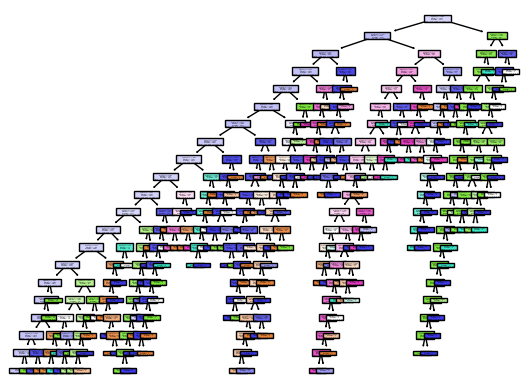

In [85]:
dt_clf = DecisionTreeClassifier(criterion='entropy', 
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight=None,
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification3') 


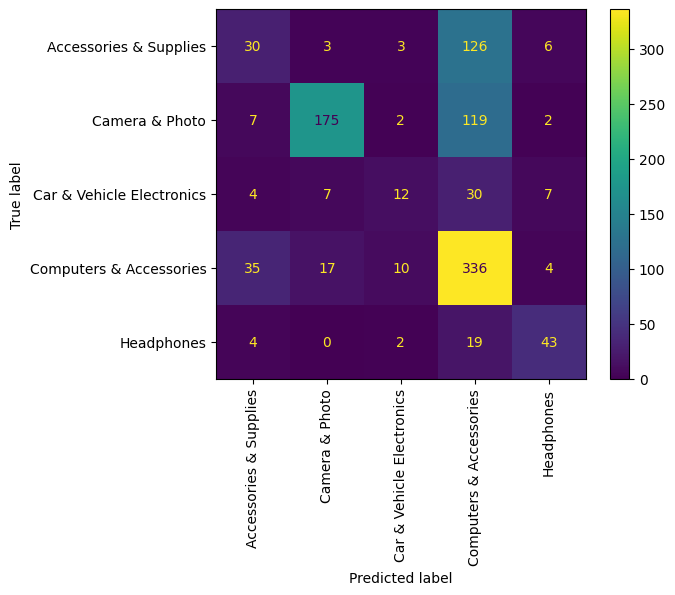

acc 0.5942173479561316
                           precision    recall  f1-score   support

   Accessories & Supplies       0.38      0.18      0.24       168
           Camera & Photo       0.87      0.57      0.69       305
Car & Vehicle Electronics       0.41      0.20      0.27        60
  Computers & Accessories       0.53      0.84      0.65       402
               Headphones       0.69      0.63      0.66        68

                 accuracy                           0.59      1003
                macro avg       0.58      0.48      0.50      1003
             weighted avg       0.61      0.59      0.57      1003



In [86]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification4.pdf'

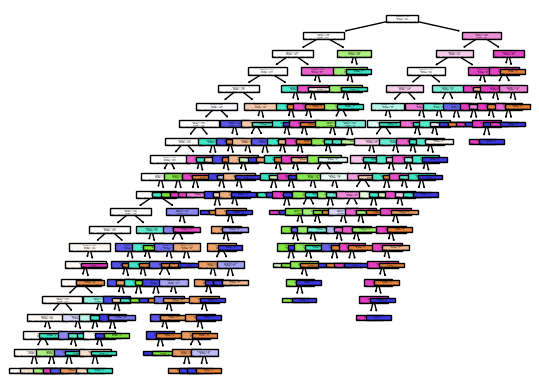

In [87]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=20, 
                            min_samples_split=8, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight='balanced',
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification4') 


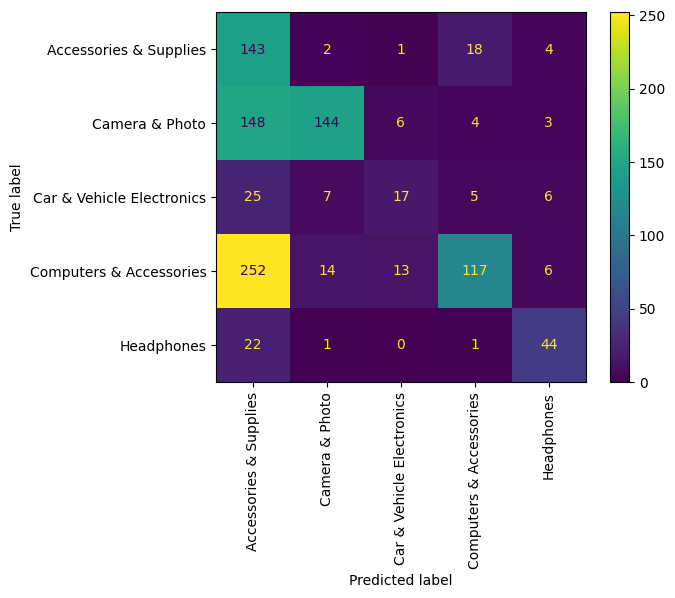

acc 0.46360917248255235
                           precision    recall  f1-score   support

   Accessories & Supplies       0.24      0.85      0.38       168
           Camera & Photo       0.86      0.47      0.61       305
Car & Vehicle Electronics       0.46      0.28      0.35        60
  Computers & Accessories       0.81      0.29      0.43       402
               Headphones       0.70      0.65      0.67        68

                 accuracy                           0.46      1003
                macro avg       0.61      0.51      0.49      1003
             weighted avg       0.70      0.46      0.49      1003



In [88]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

'dt_text_cat_classification.pdf'

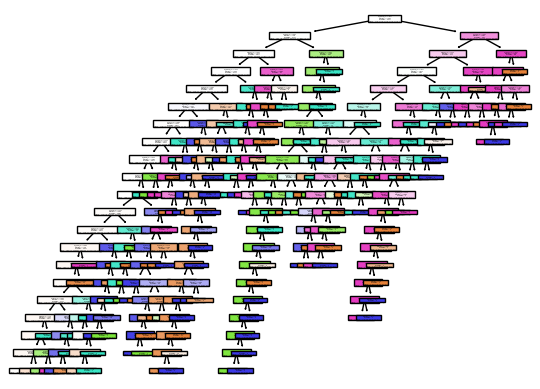

In [34]:
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight='balanced',
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification') 


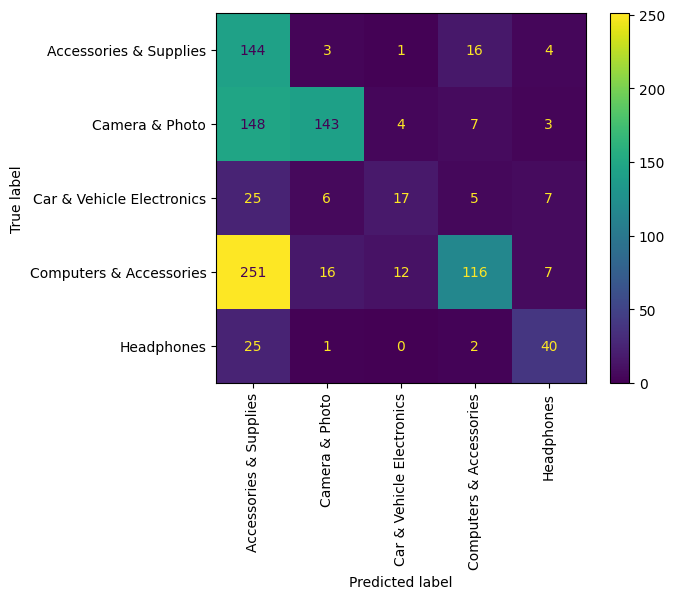

acc 0.45862412761714855
                           precision    recall  f1-score   support

   Accessories & Supplies       0.24      0.86      0.38       168
           Camera & Photo       0.85      0.47      0.60       305
Car & Vehicle Electronics       0.50      0.28      0.36        60
  Computers & Accessories       0.79      0.29      0.42       402
               Headphones       0.66      0.59      0.62        68

                 accuracy                           0.46      1003
                macro avg       0.61      0.50      0.48      1003
             weighted avg       0.69      0.46      0.48      1003



In [35]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))

In [21]:
n_classes = np.unique(y_train).shape[0]
# np.hstack(np.atleast_2d(np.unique(y_train, return_counts=True)))
np.atleast_2d(np.unique(y_train, return_counts=True)).T
# np.unique(y_train).shape[0]
display({l: np.power(y_train.shape[0], 1)/(n_classes * np.power(cnt, 1)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T})

display({l: np.power(y_train.shape[0], 0.7)/(n_classes * np.power(cnt, 0.7)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T})

display(np.unique(y_train, return_counts=True))

{'Accessories & Supplies': 1.1144444444444443,
 'Camera & Photo': 0.7183527305282006,
 'Car & Vehicle Electronics': 3.7849056603773583,
 'Computers & Accessories': 0.47535545023696685,
 'Headphones': 2.917818181818182}

{'Accessories & Supplies': 0.6656560678403207,
 'Camera & Photo': 0.4894918007411691,
 'Car & Vehicle Electronics': 1.566561828222244,
 'Computers & Accessories': 0.3666248793798699,
 'Headphones': 1.3057191000821484}

(array(['Accessories & Supplies', 'Camera & Photo',
        'Car & Vehicle Electronics', 'Computers & Accessories',
        'Headphones'], dtype=object),
 array([ 720, 1117,  212, 1688,  275]))

'dt_text_cat_classification.pdf'

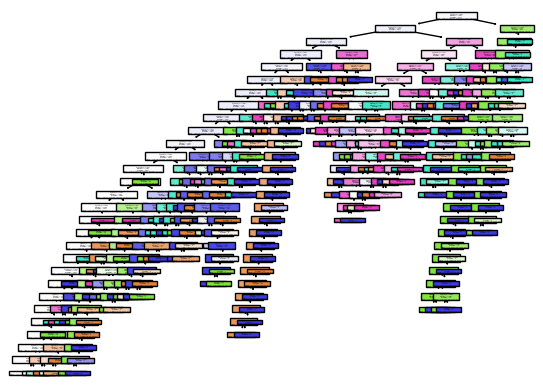

In [22]:
n_classes = np.unique(y_train).shape[0]
dt_clf = DecisionTreeClassifier(criterion='entropy',
                            splitter='best',
                            max_depth=28, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            class_weight={l: np.power(y_train.shape[0], 0.72)/(n_classes * np.power(cnt, 0.72)) \
                                          for l, cnt in np.atleast_2d(np.unique(y_train, return_counts=True)).T},
                            ccp_alpha=0.001)

dt_clf.fit(X_train, y_train)
label_names = [x.replace('&', 'and') for x in dt_clf.classes_]
# label_names


tree.plot_tree(dt_clf, filled=True)
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                      feature_names=feat_names,  
                      class_names=label_names,  
                      filled=True, rounded=True,  
                      special_characters=True)                                    
graph = graphviz.Source(dot_data) 
graph.render('dt_text_cat_classification5') 


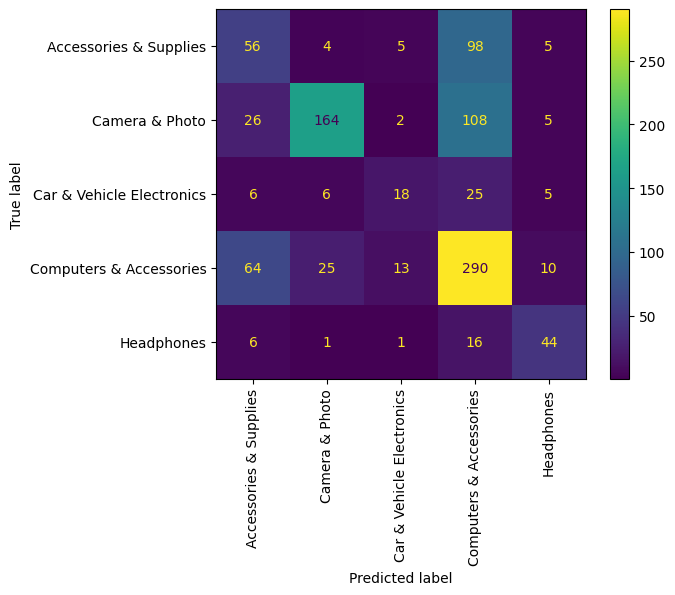

acc 0.5702891326021934
                           precision    recall  f1-score   support

   Accessories & Supplies       0.35      0.33      0.34       168
           Camera & Photo       0.82      0.54      0.65       305
Car & Vehicle Electronics       0.46      0.30      0.36        60
  Computers & Accessories       0.54      0.72      0.62       402
               Headphones       0.64      0.65      0.64        68

                 accuracy                           0.57      1003
                macro avg       0.56      0.51      0.52      1003
             weighted avg       0.60      0.57      0.57      1003



In [63]:
y_pred = dt_clf.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=dt_clf.classes_).plot()
plt.xticks(rotation=90)
plt.show()

print ("acc",accuracy_score(y_test, y_pred))

print (classification_report(y_test, y_pred))